In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import kmedias

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Reading Dataset

In [2]:
df = pd.read_csv("./datasets/clean_acath.csv")
df.rename(columns={"cad.dur": "duracion"}, inplace=True)
df.head()

,sex,age,duracion,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,228.0,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [3]:
with_disease    = df[df['sigdz'] == 1]
without_disease = df[df['sigdz'] == 0]
print(f" amount with disease: {len(with_disease)}")
print(f" amount without disease: {len(without_disease)}")

 amount with disease: 2332
 amount without disease: 1169


In [4]:
# Balance amount of positive and negative
with_disease_sample = with_disease.sample(n=len(without_disease))
df = pd.concat([without_disease, with_disease_sample])

In [5]:
# Double check no Nans
df.isna().sum()

sex         0
age         0
duracion    0
choleste    0
sigdz       0
tvdlm       0
dtype: int64

In [6]:
# Siempre tvdlm es como sigdz pero peor, la meto en el modelo? (creo que no)
df[(df["sigdz"] == 0) & (df["tvdlm"] == 1)]

,sex,age,duracion,choleste,sigdz,tvdlm


### 1.a) Dividir aleatoriamente el conjunto de datos en dos conjuntos, uno de entrenamiento y uno de prueba

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=69)
print(f"training amount: {len(train)}\ntesting amount: {len(test)}")
train.head()

training amount: 1870
testing amount: 468


,sex,age,duracion,choleste,sigdz,tvdlm
3297,1,63,1,244.0,1,1.0
327,0,57,123,242.0,0,0.0
523,0,45,5,236.0,1,1.0
2427,0,69,179,220.0,1,1.0
3474,0,54,18,185.0,0,0.0


### 1.b) Clasificar la variable categórica sigdz que indica si el paciente posee o no una enfermedad coronaria, utilizando el modelo de regresión logística y las variables numéricas. Calcular la matriz de confusión y evaluar la influencia de cada una de las variables en la probabilidad calculada

In [8]:
model = smf.glm('sigdz ~ age + choleste + duracion', train, family=sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  sigdz   No. Observations:                 1870
Model:                            GLM   Df Residuals:                     1866
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1196.0
Date:                Tue, 23 Nov 2021   Deviance:                       2392.0
Time:                        05:13:30   Pearson chi2:                 1.87e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1016
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9396      0.403    -12.243      0.000      -5.730      -4.149
age            0.0606      0.005     11.198      0.000       0.050       0.071
choleste       0.0081      0.001      6.340      0.000       0.006       0.011
duracion   -5.176e-05      0.001     -0.056      0.956      -0.002       0.002
==============================================================================
"""

En base a esto podemos evaluar la influencia de cada variable en la probabilidad calculada. Duracion tiene un P>|z| muy alto lo cual quiere decir que no lo tenemos que aceptar capaz (?) igual el coeficiente es muy bajo asi que no afecta tanto al calculo de la probabilidad (siento que igual los datos deberian estar estandarizados no?)

$Pr(sigdz = 1) = \frac{e^{intercept + c_{age}*age + c_{choleste}*choleste + c_{duracion}*duracion}}{1 + e^{intercept + c_{age}*age + c_{choleste}*choleste + c_{duracion}*duracion}}$

Luego son todos positivos osea que cuanto mas grande y mas colesterol mas chances de enfermedad coronaria

In [9]:
# Taking >= 0.5 as 1 else 0
# predictions = model.predict(test).round()
pred = model.predict(test)
p = 0.5
pred.mask(pred >= p, 1, inplace=True)
pred.mask(pred < p, 0, inplace=True)
data = {
    'y_actual': list(test["sigdz"]),
    'y_predicted': list(pred)
}
conf = pd.DataFrame(data, columns=['y_actual','y_predicted'])
conf.head()

,y_actual,y_predicted
0,0,1.0
1,0,1.0
2,1,0.0
3,1,0.0
4,1,0.0


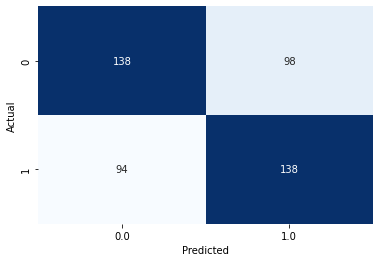

              precision    recall  f1-score   support

           0       0.59      0.58      0.59       236
           1       0.58      0.59      0.59       232

    accuracy                           0.59       468
   macro avg       0.59      0.59      0.59       468
weighted avg       0.59      0.59      0.59       468



In [10]:
confusion_matrix = pd.crosstab(conf['y_actual'], conf['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.show()
print(classification_report(conf['y_actual'], conf['y_predicted']))

### 1.c) Realizar el ejercicio 1b diferenciando mujeres y varones, o sea tomando la variable sex como factor. Interpretar los resultados. Este ejercicio puede realizarse con unalibrería

In [11]:
model_sex = smf.glm('sigdz ~ age + choleste + duracion + C(sex)', train, family=sm.families.Binomial()).fit()
model_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  sigdz   No. Observations:                 1870
Model:                            GLM   Df Residuals:                     1865
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1019.7
Date:                Tue, 23 Nov 2021   Deviance:                       2039.4
Time:                        05:13:30   Pearson chi2:                 1.91e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2560
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.4365      0.466    -13.820      0.000      -7.349      -5.524
C(sex)[T.1]    -2.1447      0.127    -16.898      0.000      -2.393      -1.896
age             0.0850      0.006     13.449      0.000       0.073       0.097
choleste        0.0126      0.001      8.603      0.000       0.010       0.015
duracion       -0.0003      0.001     -0.327      0.743      -0.002       0.002
===============================================================================
"""

Medio lo mismo que el anterior en este caso pero duracion se hace muy alto el valor de p asi que creo que es peor todavia. Igual el coeficiente es tan chico que supongo que no afecta tanto.

Lo que si se puede ver bastante notorio es que si sex=1 (osea femenino) tiene un coeficiente fuerte negativo asi que quiere decir que las mujeres tienen muchos menos chances de enfermedad coronaria que los hombres.

In [12]:
# Taking >= 0.5 as 1 else 0
# predictions = model.predict(test).round()
pred_sex = model.predict(test)
p_sex = 0.5
pred_sex.mask(pred >= p, 1, inplace=True)
pred_sex.mask(pred < p, 0, inplace=True)
data_sex = {
    'y_actual': list(test["sigdz"]),
    'y_predicted': list(pred)
}
conf_sex = pd.DataFrame(data, columns=['y_actual','y_predicted'])
conf_sex.head()

,y_actual,y_predicted
0,0,1.0
1,0,1.0
2,1,0.0
3,1,0.0
4,1,0.0


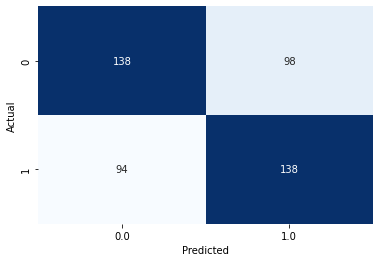

              precision    recall  f1-score   support

           0       0.59      0.58      0.59       236
           1       0.58      0.59      0.59       232

    accuracy                           0.59       468
   macro avg       0.59      0.59      0.59       468
weighted avg       0.59      0.59      0.59       468



In [13]:
confusion_matrix_sex = pd.crosstab(conf_sex['y_actual'], conf_sex['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_sex, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.show()
print(classification_report(conf_sex['y_actual'], conf_sex['y_predicted']))

###  1.d) Utilizando el modelo anterior calcular la probabilidad de que una persona tenga estrechamiento arterial si el colesterol es de 199, la edad es de 60 años y la duración es de 2 días.

Me parece que para este ejercicio basta con calcular la probabilidad haciendo esta cuenta:
$Pr(sigdz = 1) = \frac{e^{intercept + c_{age}*age + c_{choleste}*choleste + c_{duracion}*duracion}}{1 + e^{intercept + c_{age}*age + c_{choleste}*choleste + c_{duracion}*duracion}}$

In [14]:
def get_proba(model, values):
    intercept = model.params['Intercept']
    params = {model.params.axes[0][i]: p for i,p in enumerate(model.params)}
    in_exponent = intercept
    for k,v in values.items():
        in_exponent += v*params[k]
    return np.exp(in_exponent) / (1 + np.exp(in_exponent))

In [15]:
point = {
    "age": 60,
    "choleste": 199,
    "duracion": 2
}
get_proba(model, point)

0.5758805105377811

Usando el modelo del punto 1.b la probabilidad que una persona tenga estrechamiento arterial dadas las condiciones mencionadas es de 53%

In [18]:
from kmedias import Kmeans

attributes = ['age', 'duracion', 'choleste']
label = ['sigdz']

data = df[attributes]
labels = df[label]
    
train, test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=69)
print(f"training amount: {len(train)}\ntesting amount: {len(test)}")

train = train.to_numpy()
test = test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy().flatten()

#k medias
clusters_group = [50, 40, 30, 20, 10, 5, 2]
with open(f'./results/k_means_output.csv', mode='a+') as f:

    for clusters in clusters_group:
        for _ in range(10):
            # train section
            k_means = Kmeans(clusters, train)
            k_means.run(5000)
            k_means.add_cluster_classification(y_train)

            # test section
            predictions = k_means.predict(test)

            # confusion_matrix = get_confusion_matrix(predictions, test_y)
            # precision = get_accuracy(confusion_matrix)
            # plot_heatmap(confusion_matrix, f'./results/{filename}_{clusters}_clusters_confusion.jpg')
            # f.write(f'k means,{clusters},{round(precision, 4)}\n')


# k_means_program(train, test, y_train, y_test)

training amount: 1870
testing amount: 468


KeyError: "None of [Int64Index([  50,   66,  106,  153,  231,  233,  266,  281,  360,  460,  475,\n             535,  582,  587,  650,  657,  683,  776,  780,  847,  899,  999,\n            1010, 1061, 1117, 1121, 1122, 1126, 1179, 1185, 1206, 1236, 1264,\n            1267, 1278, 1281, 1291, 1357, 1392, 1428, 1509, 1664, 1754, 1758],\n           dtype='int64')] are in the [columns]"